In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import sys
module_path = os.path.abspath(os.path.join('/Users/arthurstrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
# Qiskit imports
from qiskit import pulse, transpile
from qiskit.transpiler import InstructionDurations
from qiskit.circuit import ParameterVector, QuantumCircuit, QuantumRegister, Gate, CircuitInstruction
from dynamicsbackend_estimator import DynamicsBackendEstimator
from qconfig import QiskitConfig
from quantumenvironment import QuantumEnvironment
from torch.distributions import Normal

import numpy as np
import tqdm
import time
from typing import Union, Optional, List, Sequence
from IPython.display import clear_output
import jax
jax.config.update("jax_enable_x64", True)
# tell JAX we are using CPU
jax.config.update("jax_platform_name", "cpu")
# import Array and set default backend
from qiskit_dynamics.array import Array
Array.set_default_backend('jax')

/Users/arthurstrauss/opt/anaconda3/envs/qiskit_env/lib/python3.9/site-packages/qiskit_dynamics/dispatch/backends/jax.py:34: UserWarning: The functionality in the perturbation module of Qiskit Dynamics requires a JAX version <= 0.4.6, due to a bug in JAX versions > 0.4.6. For versions 0.4.4, 0.4.5, and 0.4.6, using the perturbation module functionality requires setting os.environ['JAX_JIT_PJIT_API_MERGE'] = '0' before importing JAX or Dynamics.
  warnings.warn(


# Circuit macros for environment

Below we define functions defining our way of parametrizing the custom gate we intend to calibrate. In the pulse gate scenario, we define two functions for clearly separating the abstraction layers that are intertwined here.
The function ```apply_parametrized_circuit``` creates a custom parametrized ```Gate``` (which can be derived from a predefined Qiskit gate to retrieve its logical effect) and appends it to a ```QuantumCircuit``` given in input. The parametrization of the gate is provided by the ```params: ParameterVector``` argument of the function and is used to build a custom calibration of the gate. This custom calibration is defined in the second function called ```custom_schedule```, which builds a custom parametrized pulse schedule that can be attached to the gate calibration (see this tutorial for more info: https://qiskit.org/documentation/tutorials/circuits_advanced/05_pulse_gates.html).
In our approach, we design a custom schedule starting from the baseline calibration already available from IBMQ calibration results. The parameters of our custom schedule are in this framework deviations over baseline parameters of the original calibration, meant to evolve to address the particular circuit context in which the gate is going to be executed.

In [3]:
from qiskit.providers import Backend, BackendV1, BackendV2
from qiskit_experiments.calibration_management import Calibrations
from basis_gate_library import FixedFrequencyTransmon, EchoedCrossResonance
from copy import deepcopy
from helper_functions import determine_ecr_params
def custom_schedule(backend: Backend, physical_qubits: list, params: ParameterVector, keep_symmetry:bool=True):
    """
    Define parametrization of the pulse schedule characterizing the target gate.
    This function can be customized at will, however one shall recall to make sure that number of actions match the 
    number of pulse parameters used within the function (throught the params argument).
        :param backend: IBM Backend on which schedule shall be added
        :param physical_qubits: Physical qubits on which custom gate is applied on
        :param params: Parameters of the Schedule/Custom gate
        :param keep_symmetry: Choose if the two parts of the ECR tone shall be jointly parametrized or not

        :return: Parametrized Schedule
    """
    # Load here all pulse parameters names that should be tuned during model-free calibration.
    # Here we focus on real time tunable pulse parameters (amp, angle, duration)
    pulse_features = ["amp", "angle", "tgt_amp", "tgt_angle"]
    
    # Uncomment lines below to include pulse duration as tunable parameter
    # pulse_features.append("duration")
    # duration_window = 0
    
    global n_actions
    assert n_actions == len(params), f"Number of actions ({n_actions}) does not match length of ParameterVector {params.name} ({len(params)})" 
    
    new_params, _, _ = determine_ecr_params(backend, physical_qubits)
    
    qubits = tuple(physical_qubits)
     
    if keep_symmetry: # Maintain symmetry between the two GaussianSquare pulses
        for sched in ["cr45p", "cr45m"]: 
            for i, feature in enumerate(pulse_features):
                if feature != "duration":
                    new_params[(feature, qubits, sched)] += params[i] 
                else:
                    new_params[(feature, qubits, sched)] += pulse.builder.seconds_to_samples(duration_window * params[i])
    else:
        num_features =  len(pulse_features)
        for i, sched in enumerate(["cr45p", "cr45m"]): 
            for j, feature in enumerate(pulse_features):
                if feature != "duration":
                    new_params[(feature, qubits, sched)] += params[i*num_features + j]
                else:
                    new_params[(feature, qubits, sched)] += pulse.builder.seconds_to_samples(duration_window * params[i*num_features + j])         
    
    cals = Calibrations.from_backend(backend,[FixedFrequencyTransmon(["x", "sx"]), 
                                              EchoedCrossResonance(["cr45p", "cr45m", "ecr"])],
                                     add_parameter_defaults=True)

    # Retrieve schedule (for now, works only with ECRGate(), as no library yet available for CX)
    parametrized_schedule = cals.get_schedule("ecr", physical_qubits, assign_params=new_params)
    return parametrized_schedule

In [4]:
# Pulse gate ansatz

def apply_parametrized_circuit(qc: QuantumCircuit, params: Optional[ParameterVector]=None, tgt_register: Optional[QuantumRegister]=None):
    """
    Define ansatz circuit to be played on Quantum Computer. Should be parametrized with Qiskit ParameterVector
    This function is used to run the QuantumCircuit instance on a Runtime backend
    :param qc: Quantum Circuit instance to add the gate on
    :param params: Parameters of the custom Gate
    :param tgt_register: Quantum Register formed of target qubits
    :return:
    """
    global n_actions, backend, target
    
    if params is None:
        params = ParameterVector('theta', n_actions)
    if tgt_register is None:
        tgt_register = qc.qregs[0]

    # Choose below which target gate you'd like to calibrate
    # parametrized_gate = Gate("custom_ecr", 2, params=params.params)
    gate, physical_qubits = target["gate"], target["register"]
    parametrized_gate = gate.copy()
    parametrized_gate.params = params.params
    parametrized_schedule = custom_schedule(backend=backend, physical_qubits=physical_qubits, params=params)
    qc.add_calibration(parametrized_gate, physical_qubits, parametrized_schedule)
    qc.append(parametrized_gate, tgt_register)

## Generic information characterizing the quantum system

The algorithm is built upon Qiskit modules. To specify how to address our quantum system of interest, we therefore adopt the IBM approach to define a quantum backend, on which qubits are defined and can be accessed via control actions and measurements.

The cell below specifies:
- ```physical_qubits```: List of qubit indices which are specifically addressed by controls , namely the ones for which we intend to calibrate a gate upon or steer them in a specific quantum state. Note that this list could include less qubits than the total number of qubits, which can be useful when one wants to take into account crosstalk effects emerging from nearest-neigbor coupling.
- ```sampling_Paulis```: number of Pauli observables  to be sampled from the system: the algorithm relies on the ability to process measurement outcomes to estimate the expectation value of different Pauli operators. The more observables we provide for sampling, the more properties we are able to deduce with accuracy about the actual state that was created when applying our custom controls. For a single qubit, the possible Pauli operators are $\sigma_0=I$, $\sigma_x=X$, $\sigma_y=Y$, $\sigma_z=Z$. For a general multiqubit system, the Pauli observables are tensor products of those single qubit Pauli operators. The algorithm will automatically estimate which observables are the most relevant to sample based on the provided target. The probability distribution from which those observables are sampled is derived from the Direct Fidelity Estimation (equation 3, https://link.aps.org/doi/10.1103/PhysRevLett.106.230501) algorithm. 
- ```N_shots```: Indicates how many measurements shall be done for each provided circuit (that is a specific combination of an action vector and a Pauli observable to be sampled)
- ```n_actions```: Indicates the number of pulse/circuit parameters that characterize our parametrized quantum circuit. For our pulse level ansatz, this number will depend on the number of parameters we are willing to tune in the original two-qubit gate calibration. 
- ```estimator_options```: Options of the Qiskit Estimator primitive. The Estimator is the Qiskit module enabling an easy computation of Pauli expectation values. One can set options to make this process more reliable (typically by doing some error mitigation techniques in post-processing). Works only with Runtime Backend at the moment
- ```abstraction_level``` chosen to encode our quantum circuit. One can choose here to stick to the usual circuit model of quantum computing, by using the ```QuantumCircuit``` objects from Qiskit and therefore set the ```abstraction_level``` to ```"circuit"```. However, depending on the task at hand, one can also prefer to use a pulse description of all the operations in our circuit. This is possible for both real backends and simulators by using respectively Qiskit Runtime and Qiskit Dynamics. In this case, one should define the ansatz circuit above in a pulse level fashion, and the simulation done at the Hamiltonian level, and not only via statevector calculations. In this notebook we set the ```abstraction_level``` to ```"pulse"```. Another notebook at the gate level is available in the repo.

In [5]:
physical_qubits = [0, 1]
sampling_Paulis = 50
N_shots = 200
n_actions = 4  # Cf number of parameters in custom_schedule function above
abstraction_level = 'pulse'

## Setting up Quantum Backend

### Simulation backend initialization: Qiskit Dynamics
If you want to run the algorithm over a simulation, one can use Qiskit Dynamics for pulse level simulation of quantum circuits. Below we set the ground for declaring a ```DynamicsBackend```.

This can be done in two ways: 

1. Declare a ```DynamicsBackend``` from a ```FakeBackend``` or ```IBMBackend``` instance and use the ```from_backend()``` method to retrieve the Hamiltonian description of such backend.
2. Alternatively, you can define your own custom Hamiltonian/Linblad that should be used to simulate the multiqubit system of interest, and feed it to a ```Solver``` instance which can be used to declare the ```DynamicsBackend```.
For more information you can check Qiskit Dynamics documentation (https://qiskit.org/documentation/dynamics/apidocs/backend.html)


In [6]:
from qiskit.providers.fake_provider import FakeHanoi, FakeJakarta, FakeJakartaV2
from helper_functions import get_control_channel_map
from qiskit_dynamics import DynamicsBackend, Solver
from helper_functions import get_solver_and_freq_from_backend

fake_backend = FakeJakarta()
fake_backend_v2 = FakeJakartaV2()
control_channel_map = get_control_channel_map(fake_backend, physical_qubits)
dt = fake_backend_v2.target.dt
print("Coupling Map: ",list(fake_backend_v2.coupling_map.get_edges()))

Coupling Map:  [(5, 4), (4, 5), (1, 3), (3, 1), (6, 5), (5, 6), (3, 5), (5, 3), (2, 1), (1, 2), (0, 1), (1, 0)]


In [7]:
dynamics_options = {'seed_simulator': None, #"configuration": fake_backend.configuration(),
                    'control_channel_map': control_channel_map, 
                    "solver_options": {"method": "jax_odeint", "atol": 1e-6, "rtol": 1e-8, "hmax":dt}
                    }
qubit_properties = fake_backend_v2.qubit_properties(physical_qubits)

# Extract channel frequencies and Solver instance from backend to provide a pulse level simulation enabling
# fidelity benchmarking
channel_freq, solver = get_solver_and_freq_from_backend(
    backend=fake_backend,
    subsystem_list=physical_qubits,
    rotating_frame="auto",
    evaluation_mode="dense",
    rwa_cutoff_freq=None,
    static_dissipators=None,
    dissipator_channels=None,
    dissipator_operators=None
)
calibration_files=None

In [8]:
# Using the from_backend method

dynamics_backend = DynamicsBackend.from_backend(fake_backend, subsystem_list=physical_qubits, **dynamics_options)
dynamics_backend.target.qubit_properties = qubit_properties

In [9]:
print(qubit_properties)

[QubitProperties(t1=0.00014344345919892887, t2=2.561315610407576e-05, frequency=5236351487.460436), QubitProperties(t1=0.00014443980054869816, t2=2.325239318431975e-05, frequency=5014160311.321986)]


In [10]:
from qiskit.quantum_info import Operator
from qiskit_dynamics import Solver, Signal
dim = 2
dt = 1/4.5e9
v0 = 4.86e9
anharm0 = -0.32e9
r0 = 0.22e9

v1 = 4.97e9
anharm1 = -0.32e9
r1 = 0.26e9

X = Operator.from_label('X')
Y = Operator.from_label('Y')
Z = Operator.from_label('Z')
s_p = 0.5 * (X + 1j * Y)

solver = Solver(
    static_hamiltonian=.5 * 2 * np.pi * v0 * Z,
    hamiltonian_operators=[2 * np.pi * r0 * X],
    rotating_frame = .5 * 2 * np.pi * v0 * Z,
    hamiltonian_channels=["d0"],
    channel_carrier_freqs={"d0": v0},
    dt=dt,
    evaluation_mode="dense"
    
)


In [11]:
dim = 2

v = [prop.frequency for prop in qubit_properties]
v0 = 4.86e9
anharm0 = -0.32e9
r0 = 0.22e9

v1 = 4.97e9
anharm1 = -0.32e9
r1 = 0.26e9

J = 0.002e9

a = np.diag(np.sqrt(np.arange(1, dim)), 1)
adag = np.diag(np.sqrt(np.arange(1, dim)), -1)
N = np.diag(np.arange(dim))

ident = np.eye(dim, dtype=complex)
full_ident = np.eye(dim**2, dtype=complex)

N0 = np.kron(ident, N)
N1 = np.kron(N, ident)

a0 = np.kron(ident, a)
a1 = np.kron(a, ident)

a0dag = np.kron(ident, adag)
a1dag = np.kron(adag, ident)


static_ham0 = 2 * np.pi * v0 * N0 + np.pi * anharm0 * N0 * (N0 - full_ident)
static_ham1 = 2 * np.pi * v1 * N1 + np.pi * anharm1 * N1 * (N1 - full_ident)

static_ham_full = static_ham0 + static_ham1 + 2 * np.pi * J * ((a0 + a0dag) @ (a1 + a1dag))

drive_op0 = 2 * np.pi * r0 * (a0 + a0dag)
drive_op1 = 2 * np.pi * r1 * (a1 + a1dag)

# build solver
dt = 1/4.5e9

solver = Solver(
    static_hamiltonian=static_ham_full,
    hamiltonian_operators=[drive_op0, drive_op1, drive_op0, drive_op1, drive_op1, drive_op0],
    rotating_frame=static_ham_full,
    hamiltonian_channels=["d0", "d1", "u0", "u1", "u2", "u3"],
    channel_carrier_freqs={"d0": v0, "d1": v1, "u0": v1, "u1": v0, "u2":v0, "u3": v1},
    dt=dt,
    evaluation_mode="sparse"
)
# Consistent solver option to use throughout notebook


In [12]:
solver_options = {"method": "jax_odeint", "atol": 1e-6, "rtol": 1e-8, 'hmax':dt}

custom_backend2 = DynamicsBackend(
    solver=solver,
    #target = fake_backend_v2.target,
    subsystem_dims=[dim, dim], # for computing measurement data
    solver_options=solver_options, # to be used every time run is called
)
backend_target = custom_backend2.target
channel_freq = None
calibration_files = None
do_calibrations = True
# qubit properties

In [13]:
print(custom_backend2.target)

Target
Number of qubits: 2
Instructions:
	measure
		(0,):
			With pulse schedule calibration
		(1,):
			With pulse schedule calibration



## Select backend

In [14]:
# Choose backend among the set defined above: {runtime_backend, dynamics_backend, custom_backend}
backend = custom_backend2

In [15]:
# Example of target gate
from qiskit.circuit.library.standard_gates import ECRGate, XGate
ECR_tgt = {"gate": ECRGate(), "register": physical_qubits}
target = ECR_tgt
print(target)

{'gate': Instruction(name='ecr', num_qubits=2, num_clbits=0, params=[]), 'register': [0, 1]}


In [16]:
from helper_functions import perform_standard_calibrations

cals, results  = perform_standard_calibrations(backend)

Starting Rabi experiment for qubit 0...
Rabi experiment for qubit 0 done.
Starting Drag experiment for qubit 0...
Drag experiments done for qubit 0 done.
Starting Rabi experiment for qubit 1...
Rabi experiment for qubit 1 done.
Starting Drag experiment for qubit 1...
Drag experiments done for qubit 1 done.
All single qubit calibrations are done
{(0, 1): 0, (1, 0): 1}
Updated Instruction Schedule Map <InstructionScheduleMap(1Q instructions:
  q0: {'x', 'z', 'reset', 'id', 'sx', 's', 'tdg', 'h', 'rz', 't', 'measure', 'sdg'}
  q1: {'x', 'z', 'reset', 'id', 'sx', 's', 'tdg', 'h', 'rz', 't', 'measure', 'sdg'}
Multi qubit instructions:
  (0, 1): {'cr45p', 'ecr', 'cr45m'}
  (1, 0): {'cr45p', 'ecr', 'cr45m'}
)>


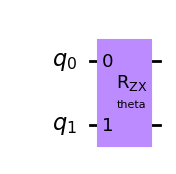

In [28]:
from qiskit.circuit import Parameter
from qiskit.primitives import BackendEstimator
estimator = BackendEstimator(backend)
param = Parameter("theta")
qc = QuantumCircuit(2)
qc.rzx(param, 0,1)
qc.draw("mpl")

In [29]:
from qiskit.quantum_info import SparsePauliOp
obs = SparsePauliOp.from_list([("XX" ,1.), ('YY', 1.)])

In [30]:
estimator.run(qc, obs, [0.1])

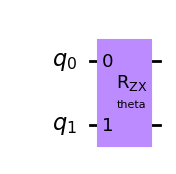

In [34]:
estimator.preprocessed_circuits[0][0].draw("mpl")

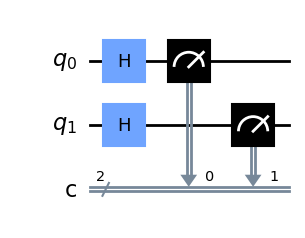

In [40]:
estimator.preprocessed_circuits[0][1][0].draw("mpl")

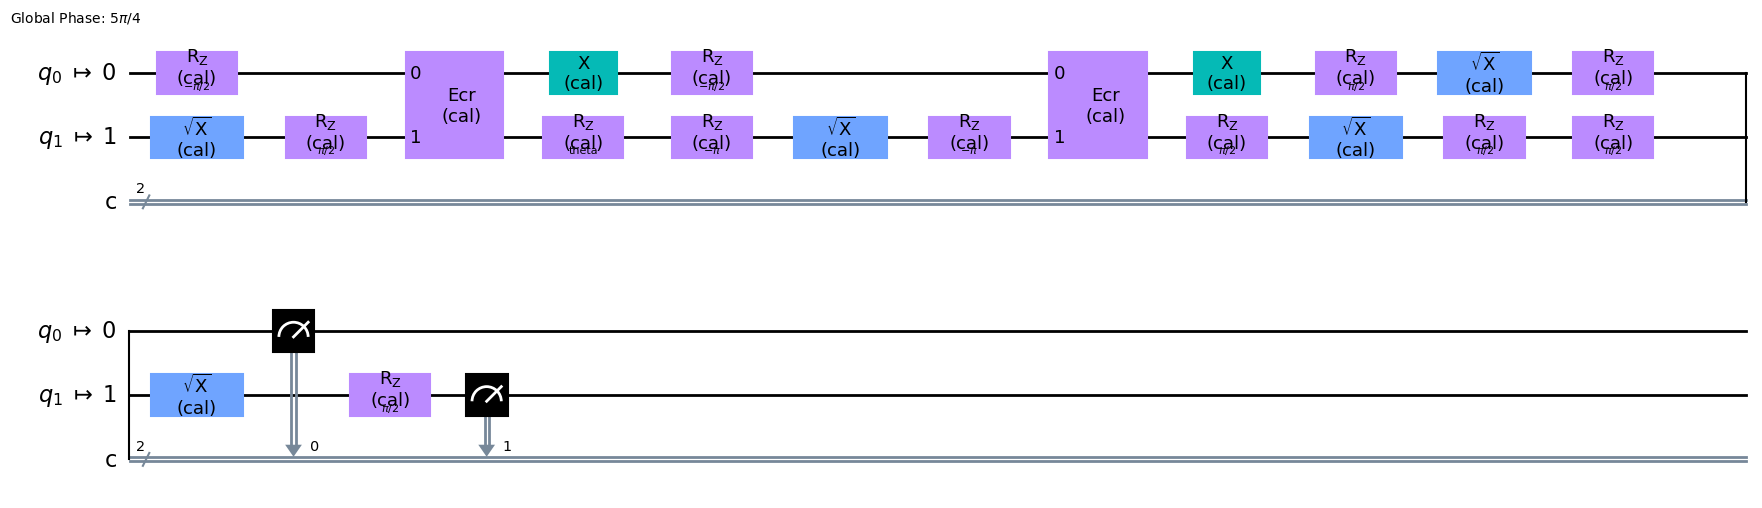

In [39]:
estimator.transpiled_circuits[0].draw("mpl")

In [18]:
from qiskit.compiler import schedule
qc2 = transpile(qc,backend)
schedule(qc2,backend)

Schedule((0, Play(Drag(duration=160, sigma=40, beta=0, amp=0.05028928, angle=0), DriveChannel(1))), (160, ShiftPhase(1.5707963268, DriveChannel(0))), (160, ShiftPhase(-1.5707963268, DriveChannel(1))), (160, ShiftPhase(-1.5707963268, ControlChannel(0))), (160, ShiftPhase(1.5707963268, ControlChannel(1))), (160, Play(GaussianSquare(duration=1168, sigma=64, width=912, amp=0, angle=0), DriveChannel(1))), (160, Play(GaussianSquare(duration=1168, sigma=64, width=912, amp=0.5, angle=0), ControlChannel(0))), (1328, Play(Drag(duration=160, sigma=40, beta=6.0097120265, amp=0.1185599, angle=0), DriveChannel(0))), (1488, Play(GaussianSquare(duration=1168, sigma=64, width=912, amp=0, angle=3.1415926536), DriveChannel(1))), (1488, Play(GaussianSquare(duration=1168, sigma=64, width=912, amp=0.5, angle=3.1415926536), ControlChannel(0))), (2656, ShiftPhase(-1.0*theta, DriveChannel(1))), (2656, ShiftPhase(3.1415926536, DriveChannel(1))), (2656, ShiftPhase(-1.0*theta, ControlChannel(0))), (2656, ShiftPha

In [19]:
from qiskit.quantum_info import SparsePauliOp
obs = SparsePauliOp.from_list([("XX", 1.), ("ZZ", 1),("IZ",1)])


In [20]:
job = estimator.run(qc, obs, [3.14])

In [21]:
with pulse.build() as sched:
    pulse.play(pulse.Drag(param, 0.1, 20, 0.), pulse.DriveChannel(0))
    pulse.delay(40, pulse.DriveChannel(0))
    pulse.play(pulse.Drag(150, 0.1, 20, 0.), pulse.DriveChannel(0))


In [22]:
sched.draw()

2


UnassignedDurationError: 'All instruction durations should be assigned before creating `Schedule`.Please check `.parameters` to find unassigned parameter objects.'

In [9]:
def concatenate2(**kwargs):
    return kwargs
def concatenate(**kwargs):
    print(kwargs)
    for key in kwargs:
        if key == "Yo":
            kwargs.pop(key)
            break
    print(concatenate2(**kwargs))
    return kwargs

concatenate(hey="Well", ho= "Ay", Yo= "YI")



{'hey': 'Well', 'ho': 'Ay', 'Yo': 'YI'}
{'hey': 'Well', 'ho': 'Ay'}


{'hey': 'Well', 'ho': 'Ay'}